In [1]:
import torch
import torchvision.models as models
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tqdm import tqdm


# Set device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [2]:
def create_resnet_model():
    resnet_model = models.resnet50(pretrained=True)
    # Adding batch normalization and dropout to improve generalization and reduce overfitting
    resnet_model.fc = nn.Sequential(
        nn.Linear(resnet_model.fc.in_features, 256),  # First fully connected layer
        nn.BatchNorm1d(256),                          # Batch normalization layer
        nn.ReLU(),                                    # Activation function
        nn.Dropout(0.5),                              # Dropout to reduce overfitting
        nn.Linear(256, 128),                          # Second fully connected layer
        nn.ReLU(),                                    # Activation function
        nn.Linear(128, 1),                            # Output layer
        nn.Sigmoid()                                  # Sigmoid activation for binary classification
    )
    return resnet_model.to(device)  # Move the model to the appropriate device


def create_densenet_model():
    densenet_model = models.densenet169(pretrained=True)
    # Revise the classifier to include batch normalization and dropout
    densenet_model.classifier = nn.Sequential(
        nn.Linear(densenet_model.classifier.in_features, 256),  # Increase the number of units
        nn.BatchNorm1d(256),  # Batch normalization
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout to reduce overfitting
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    return densenet_model.to(device) 


In [3]:
resnet_model = create_resnet_model()
densenet_model = create_densenet_model()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weig

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Adds random horizontal flipping
    transforms.RandomRotation(15),      # Randomly rotates the image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder('data/train', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageFolder('data/val', transform=train_transform)
val_loader = DataLoader(val_dataset, batch_size=32)

In [5]:
def train_and_evaluate(model, train_loader, val_loader, epochs=5, learning_rate=0.005):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)  # Adding weight decay for L2 regularization
    best_val_accuracy = 0
    model.train()

    for epoch in range(epochs):
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

In [6]:
trained_model_densenet = train_and_evaluate(densenet_model, train_loader, val_loader)

Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


In [7]:
trained_model_resnet = train_and_evaluate(resnet_model, train_loader, val_loader)

Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████████| 277/277 [02:49<00:00,  1.63it/s]


In [8]:
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.round(outputs).cpu().numpy().flatten()  # Flatten predictions
            all_preds.extend(preds)
            all_labels.extend(labels.numpy().flatten())  # Flatten labels
    print("Number of predictions:", len(all_preds))
    print("Number of labels:", len(all_labels))
    return np.array(all_preds), np.array(all_labels)


def print_evaluation_results(model, loader):
    preds, labels = get_predictions(model, loader)
    print("Classification Report:")
    print(classification_report(labels, preds, target_names=['Not Fractured', 'Fractured']))

    

    conf_matrix = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fractured', 'Fractured'], yticklabels=['Not Fractured', 'Fractured'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute validation loss and accuracy
    criterion = torch.nn.BCELoss()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(loader.dataset)
    accuracy = correct / total

    print(f'Loss: {loss}, Accuracy: {accuracy}')
    return loss, accuracy

Number of predictions: 600
Number of labels: 600
Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.81      0.60      0.69       360
    Fractured       0.57      0.80      0.66       240

     accuracy                           0.68       600
    macro avg       0.69      0.70      0.68       600
 weighted avg       0.72      0.68      0.68       600



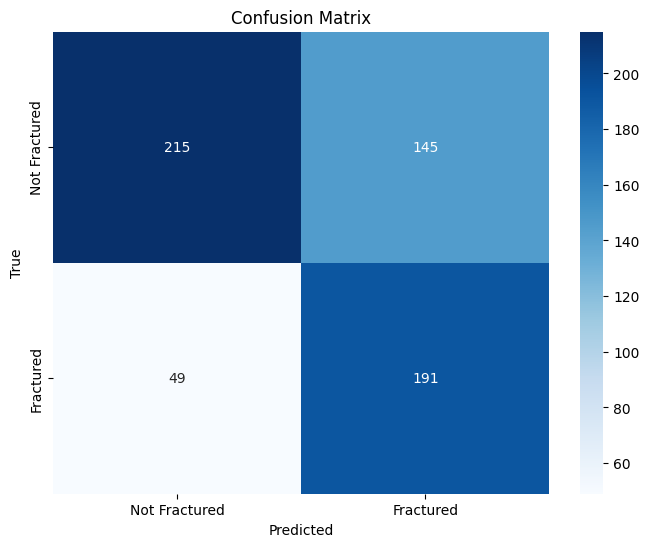

Loss: 0.0006171782733872533, Accuracy: 0.66



Number of predictions: 8863
Number of labels: 8863
Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.94      0.66      0.77      4480
    Fractured       0.73      0.95      0.83      4383

     accuracy                           0.80      8863
    macro avg       0.83      0.81      0.80      8863
 weighted avg       0.84      0.80      0.80      8863



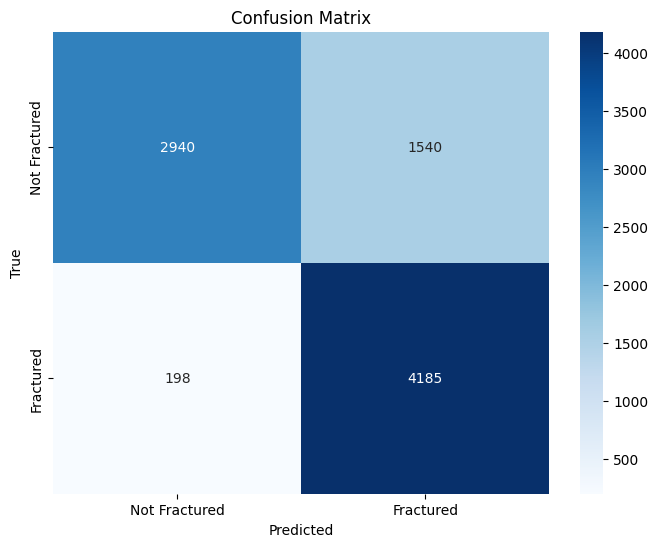

Loss: 4.489953789743595e-05, Accuracy: 0.7998420399413291


In [9]:
densenet_l_val, densenet_a_val = print_evaluation_results(trained_model_densenet, val_loader)
print("\n\n")
densenet_l_train, densenet_a_train = print_evaluation_results(trained_model_densenet, train_loader)

Number of predictions: 600
Number of labels: 600
Classification Report:
               precision    recall  f1-score   support

Not Fractured       0.00      0.00      0.00       360
    Fractured       0.40      1.00      0.57       240

     accuracy                           0.40       600
    macro avg       0.20      0.50      0.29       600
 weighted avg       0.16      0.40      0.23       600



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

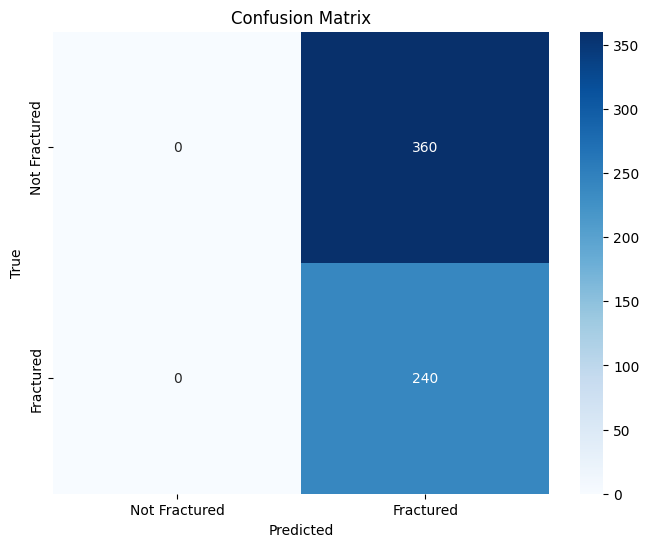

Loss: 0.0006043555331416428, Accuracy: 0.4



Number of predictions: 8863
Number of labels: 8863
Classification Report:
               precision    recall  f1-score   support

Not Fractured       1.00      0.04      0.08      4480
    Fractured       0.51      1.00      0.67      4383

     accuracy                           0.52      8863
    macro avg       0.75      0.52      0.38      8863
 weighted avg       0.76      0.52      0.37      8863



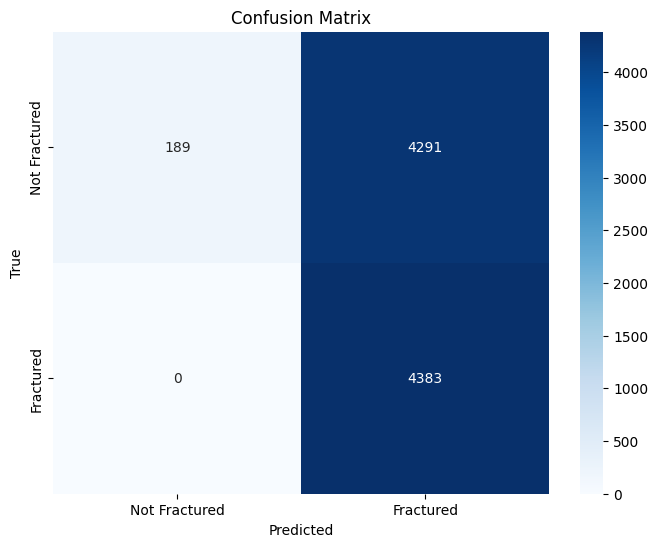

Loss: 8.310162229463458e-05, Accuracy: 0.5158524201737561


In [10]:
resnet_l_val, resnet_a_val = print_evaluation_results(trained_model_resnet, val_loader)
print("\n\n")
resnet_l_train, resnet_a_train = print_evaluation_results(trained_model_resnet, train_loader)

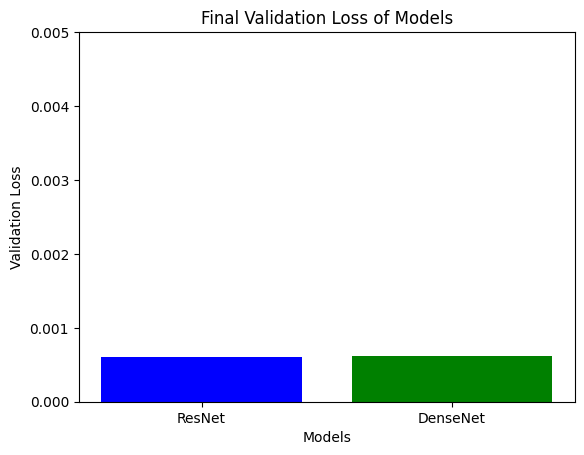

In [11]:
def plot_model_performance(models, accuracies):
    plt.bar(models, accuracies, color=['blue', 'green'])
    plt.title('Final Validation Loss of Models')
    plt.xlabel('Models')
    plt.ylabel('Validation Loss')
    plt.ylim(0, 0.005)
    plt.show()

# Example usage (assuming accuracies are calculated during or after model evaluation)
models = ['ResNet', 'DenseNet']
accuracies = [resnet_l_val.item(), densenet_l_val.item()]  # Example accuracies
plot_model_performance(models, accuracies)

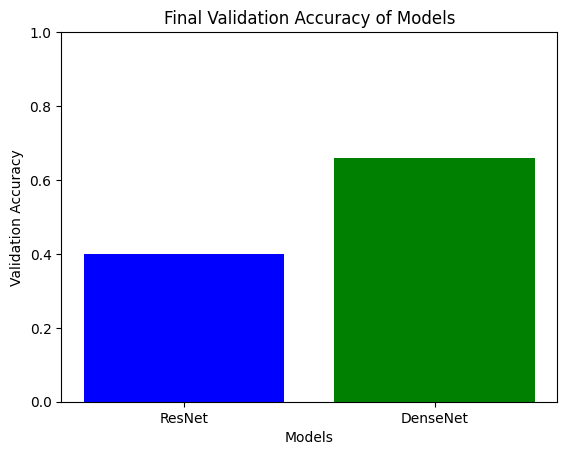

In [12]:
def plot_model_performance(models, accuracies):
    plt.bar(models, accuracies, color=['blue', 'green', 'red'])
    plt.title('Final Validation Accuracy of Models')
    plt.xlabel('Models')
    plt.ylabel('Validation Accuracy')
    plt.ylim(0, 1)
    plt.show()

# Example usage (assuming accuracies are calculated during or after model evaluation)
models = ['ResNet', 'DenseNet']
accuracies = [resnet_a_val, densenet_a_val]  # Example accuracies
plot_model_performance(models, accuracies)

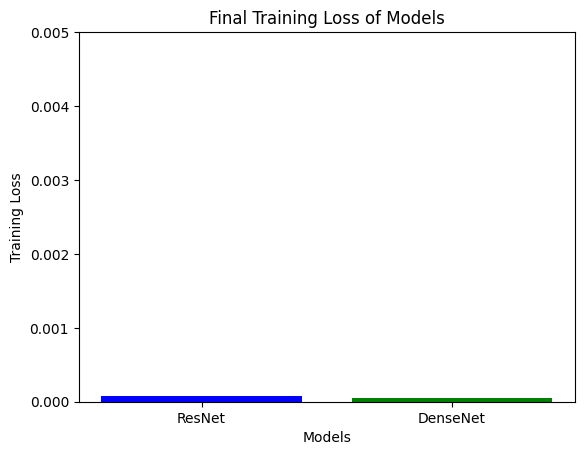

In [13]:
def plot_model_performance(models, accuracies):
    plt.bar(models, accuracies, color=['blue', 'green'])
    plt.title('Final Training Loss of Models')
    plt.xlabel('Models')
    plt.ylabel('Training Loss')
    plt.ylim(0, 0.005)
    plt.show()

# Example usage (assuming accuracies are calculated during or after model evaluation)
models = ['ResNet', 'DenseNet']
accuracies = [resnet_l_train.item(), densenet_l_train.item()]  # Example accuracies
plot_model_performance(models, accuracies)

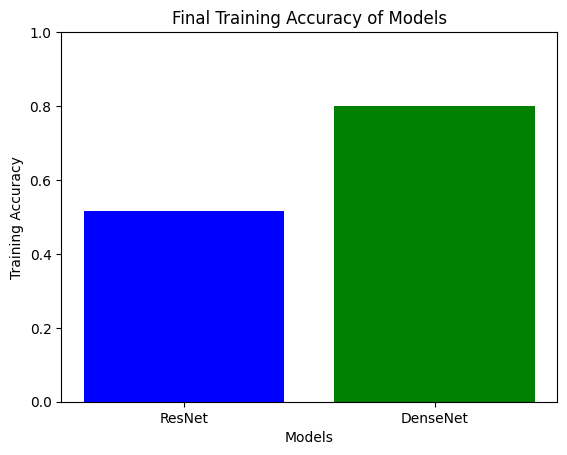

In [14]:
def plot_model_performance(models, accuracies):
    plt.bar(models, accuracies, color=['blue', 'green', 'red'])
    plt.title('Final Training Accuracy of Models')
    plt.xlabel('Models')
    plt.ylabel('Training Accuracy')
    plt.ylim(0, 1)
    plt.show()

# Example usage (assuming accuracies are calculated during or after model evaluation)
models = ['ResNet', 'DenseNet']
accuracies = [resnet_a_train, densenet_a_train]  # Example accuracies
plot_model_performance(models, accuracies)